# Computing ground-truth generalized likelihood
via the integral:

$$ \mathcal{L}(\theta|x_o) = e^{-\beta \int{p(x|\theta)d(x,x_o)dx}} $$

where

- $p(x|\theta)$ is given analytically by the simulator,
- $d(x,x_o)$ is the chosen distance function in data space,
- $\beta$ is a scaling factor over distance (temperature).

or, via Monte Carlo estimate:

$$ e^{-\beta \mathbb{E}_{p(x|\theta)} \left[ d(x,x_o) \right]} $$

---

to dos:
- write likelihood_fn for the other tasks

In [1]:
import sbibm
import torch
import matplotlib.pyplot as plt

from sbi.inference import MCMCPosterior, RejectionPosterior
from sbi.inference.potentials.base_potential import BasePotential
from sbi.utils import BoxUniform

# from sbi.utils.gbi import build_generalized_log_likelihood, GBIPotential, mse_dist
from sbi.utils.torchutils import atleast_2d
# from sbi.inference import SNLE, RejectionPosterior, likelihood_estimator_based_potential

In [2]:
def make_2d_grid(d1_bounds, d2_bounds, d1_res=100, d2_res=100):
    x1 = torch.linspace(*d1_bounds, d1_res)
    x2 = torch.linspace(*d2_bounds, d2_res)
    xs = torch.stack(torch.meshgrid(x1, x2))
    xs = torch.reshape(xs, (2, (d1_res)*(d2_res))).T
    dx = torch.diff(x1).mean()*torch.diff(x2).mean()
    return xs, dx

In [3]:
def mse_dist(xs, x_o):
    return torch.mean((xs - x_o)**2, dim=1)

def reference_generalized_loglikelihood(thetas, x_o, xs, dx, dist_func, log_prob_fn):
    # pad batch dimension
    thetas = atleast_2d(thetas)
    # technically have to account for the dx to normalize 
    integral = torch.stack([(dist_func(xs, x_o) * (log_prob_fn(theta, xs).exp()) * dx).sum() for theta in thetas])
    
    return integral

def reference_generalized_loglikelihood_samples(thetas, x_o, dist_func, simulator, n_per_theta=100):
    # pad batch dimension
    thetas = atleast_2d(thetas)
    integral_mc = torch.stack([dist_func(simulator(theta.repeat((n_per_theta, 1))), x_o).mean() for theta in thetas])
    
    return integral_mc

In [4]:
print(sbibm.get_available_tasks())

task_name =  "two_moons" # "gaussian mixture" has no likelihood
obs_num = 3

task = sbibm.get_task(task_name)
log_prob_fn = task._likelihood
prior = task.get_prior()
x_o = task.get_observation(num_observation=obs_num)

xs, dx = make_2d_grid((-1.5,1.5), (-1.5, 1.5), 200,200)
th_res = (100, 100)
thetas, dth = make_2d_grid((-1,1), (-1,1), th_res[0], th_res[1])

['two_moons', 'gaussian_mixture', 'gaussian_linear', 'bernoulli_glm', 'gaussian_linear_uniform', 'slcp', 'sir', 'lotka_volterra', 'slcp_distractors', 'bernoulli_glm_raw']


/home/rdgao/miniconda3/envs/gbi/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
gl = reference_generalized_loglikelihood(thetas, x_o, xs, dx, mse_dist, log_prob_fn)
gl = torch.reshape(gl, th_res)

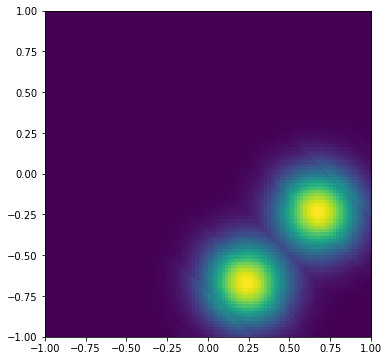

In [6]:
beta = 100
plt.figure(figsize=(6,6))
_ = plt.imshow((gl * -beta).exp().numpy().T, extent=[-1,1,-1,1], origin='lower')

In [7]:
class GBIPotential(BasePotential):
    allow_iid_x = False
    def __init__(self, prior, x_o, gen_llh_fn, lh_type, beta=1.):
        super().__init__(prior, x_o)
        self.gen_llh_fn = gen_llh_fn
        self.lh_type = lh_type
        
    def __call__(self, theta, track_gradients = True):
        # should fix this, some global variables are accessed here, e.g.,
        # xs, which is the x_grid, the distance_func, the simulator, etc.        
        if self.lh_type == 'integral':
            # integral based
            return -beta * self.gen_llh_fn(theta, self.x_o, xs, dx, mse_dist, log_prob_fn) + self.prior.log_prob(theta)
        elif self.lh_type == 'sample':
            # sampled based
            return -beta * self.gen_llh_fn(theta, self.x_o, mse_dist, simulator, n_per_theta=500) + self.prior.log_prob(theta)

In [8]:
beta = 100
prior = BoxUniform(low=torch.Tensor((-1, -1)), high=torch.Tensor((1, 1)))

# integral-based samples
gbi_potential_integral = GBIPotential(prior, x_o, reference_generalized_loglikelihood, lh_type='integral', beta=beta)
sampler = MCMCPosterior(gbi_potential_integral, prior)
theta_posterior_samples = sampler.sample((50,))
theta_np_integral = theta_posterior_samples.numpy()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

(-1.0, 1.0)

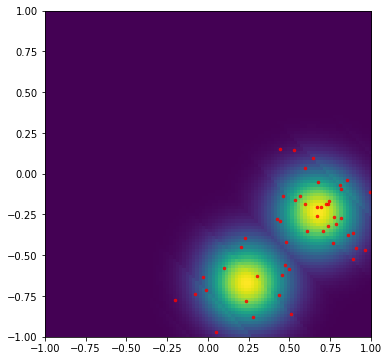

In [9]:
plt.figure(figsize=(6,6))
plt.imshow((-beta*gl).exp().numpy().T, extent=[-1,1,-1,1], origin='lower')
plt.plot(theta_np_integral[:,0], theta_np_integral[:,1], 'r.', ms=5, alpha=0.8)
plt.xlim([-1,1]); plt.ylim([-1,1])

In [11]:
simulator = task.get_simulator()
gl_sample = reference_generalized_loglikelihood_samples(thetas, x_o, mse_dist, simulator, n_per_theta=500)
gl_sample = torch.reshape(gl_sample, th_res)

In [13]:
# sample-based samples
beta = 100
gbi_potential_sample = GBIPotential(prior, x_o, reference_generalized_loglikelihood_samples, lh_type='sample', beta=beta)
sampler = RejectionPosterior(gbi_potential_sample, prior)
theta_posterior_samples = sampler.sample((50,))
theta_np_sample = theta_posterior_samples.numpy()

/home/rdgao/miniconda3/envs/gbi/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

(-1.0, 1.0)

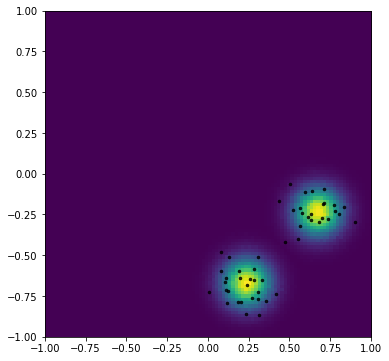

In [14]:
plt.figure(figsize=(6,6))
plt.imshow((-beta*gl_sample).exp().numpy().T, extent=[-1,1,-1,1], origin='lower')
plt.plot(theta_np_sample[:,0], theta_np_sample[:,1], 'k.', ms=5, alpha=0.8)
plt.xlim([-1,1]); plt.ylim([-1,1])

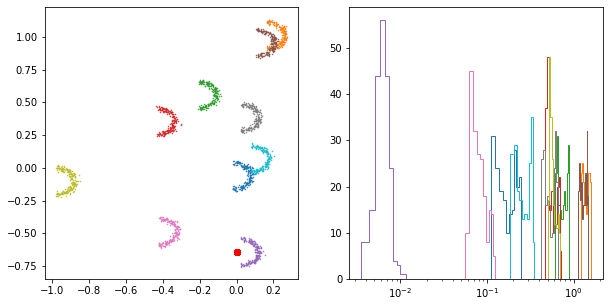

In [15]:
dist_func = mse_dist
import numpy as np
plt.figure(figsize=(10,5))
for n in np.random.choice(len(thetas), 10):
    plt.subplot(1,2,1)
    xs = simulator(thetas[n].repeat((200, 1)))
    plt.plot(xs[:,0].numpy(), xs[:,1].numpy(), '.', ms=1)
    plt.plot(x_o[:,0], x_o[:,1], 'ro')
    
    plt.subplot(1,2,2)
    d = dist_func(xs, x_o)
    plt.hist(d, histtype='step')
    
plt.xscale('log')

# Do this for all tasks
- analytical likelihood:
    - two moons
    - gaussian linear uniform
- sample-based likelihood:
    - slcp / lotka-volterra?
    - another